In [1]:
import torch
import torchvision
import torchvision.models as models
from   torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

default_params = {
    "batch_size_train": 64,
    "batch_size_test" : 100,
    "random_seed"     : 48,
    "learning_rate"   : 0.001,
    "momentum"        : 0.5

}

In [3]:
transformers = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.Grayscale(3),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
train_dataset_cifa = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transformers)
train_loader_cifa = torch.utils.data.DataLoader(train_dataset_cifa, batch_size=default_params["batch_size_train"], shuffle=True)
test_dataset_cifa = torchvision.datasets.CIFAR10('./data', train=False,download=True, transform=transformers)
test_loader_cifa = torch.utils.data.DataLoader(test_dataset_cifa, batch_size=default_params["batch_size_test"], shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
resnet18 = models.resnet18()
vgg = models.vgg16()

In [6]:
def get_class_count(dataset):
  class_dict = {} 
  for img, label in dataset:
    class_dict[label] = class_dict.get(label, 0) + 1
  for label in class_dict.keys(): 
    print("Images belonging to " + str(label) + " are: " + str(class_dict[label]))


In [8]:
get_class_count(train_dataset_cifa)

Images belonging to 6 are: 5000
Images belonging to 9 are: 5000
Images belonging to 4 are: 5000
Images belonging to 1 are: 5000
Images belonging to 2 are: 5000
Images belonging to 7 are: 5000
Images belonging to 8 are: 5000
Images belonging to 3 are: 5000
Images belonging to 5 are: 5000
Images belonging to 0 are: 5000


In [7]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [8]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, network.parameters()), lr=default_params["learning_rate"],momentum=default_params["momentum"])
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [9]:
from torch.utils.data import random_split

val_size = 5000
train_size = len(train_dataset_cifa) - val_size
train_ds, val_ds = random_split(train_dataset_cifa, [train_size, val_size])
print("Number of samples in training = {} and validation dataset = {} for CIFA10 dataset".format(len(train_ds), len(val_ds)))
val_loader_cifa = torch.utils.data.DataLoader(val_ds, default_params['batch_size_train']*2)

Number of samples in training = 45000 and validation dataset = 5000 for CIFA10 dataset


In [10]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
train_loader = DeviceDataLoader(train_loader_cifa, device)
val_loader = DeviceDataLoader(val_loader_cifa, device)
test_loader = DeviceDataLoader(test_loader_cifa, device)


In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [12]:
class CRNN(ImageClassificationBase):
    def __init__(self,resnet18, vgg):
        super(CRNN, self).__init__()
        self.features_resnet = nn.Sequential(*(list(resnet18.children())[0:8]))
        self.features_vgg = nn.Sequential(*list(vgg.features))
        
        
        self.cnn1 =  nn.Conv2d(512, 128, 7)
        self.classifier = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32,10)
        )
        self.flat = nn.Flatten()
    def forward(self, inputs):
        resnet_feature = self.features_resnet(inputs)
        resnet_feature = self.cnn1(resnet_feature)

        vgg_feature = self.features_vgg(inputs)
        vgg_feature = self.cnn1(vgg_feature)        


        f = torch.cat((vgg_feature, resnet_feature),1)
        f = self.flat(f)
        
        y  = self.classifier(f)
        
        return y

network = CRNN(resnet18, vgg)


In [17]:
# network.features_resnet.requires_grad = False
# network.features_vgg.requires_grad = False 

In [13]:
network = to_device(network, device)



In [14]:
history = [evaluate(network, val_loader)]
history += fit(10 , network, train_loader, val_loader)

Epoch [0], val_loss: 2.1495, val_acc: 0.1992
Epoch [1], val_loss: 1.9652, val_acc: 0.2498
Epoch [2], val_loss: 1.8730, val_acc: 0.2873
Epoch [3], val_loss: 1.8011, val_acc: 0.3316
Epoch [4], val_loss: 1.7280, val_acc: 0.3547
Epoch [5], val_loss: 1.6329, val_acc: 0.3941
Epoch [6], val_loss: 1.5762, val_acc: 0.4291
Epoch [7], val_loss: 1.5200, val_acc: 0.4529
Epoch [8], val_loss: 1.4758, val_acc: 0.4691
Epoch [9], val_loss: 1.4155, val_acc: 0.4814


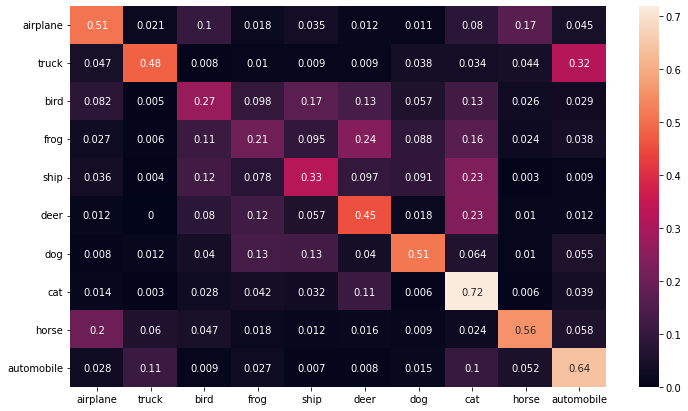

In [15]:
def print_confusion_matrix(test_loader, classes):
  y_pred = []
  y_true = []
  # iterate over test data
  for inputs, labels in test_loader:
    inputs = inputs.to(device)
    output = network(inputs) # Feed Network
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth
  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)
  plt.savefig('output.png')
print_confusion_matrix(test_loader,set(test_dataset_cifa.classes))

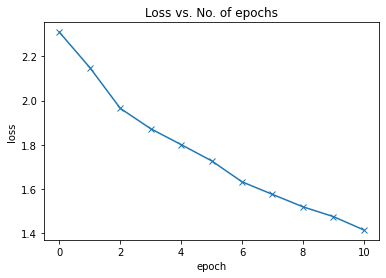

In [16]:
plot_losses(history)

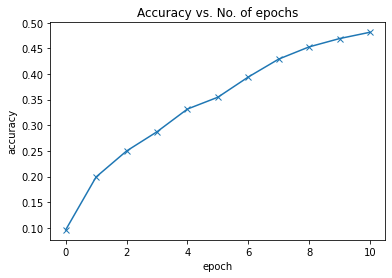

In [17]:
plot_accuracies(history)

In [18]:
from torchsummary import summary

In [20]:
summary(network,(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,